In [1]:
import os
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_etf_data(ETF):
    NNtype = "RNN"
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
    
    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'
    

    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    return (trainloader, trainmu, trainsigma), (validloader, validmu, validsigma), (testloader, testmu, testsigma)


In [3]:
import torch.nn as nn 

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers= 1)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    

In [4]:
def train_model(model, traindata, validdata, params):
    train_loss = []
    val_loss = []
    
    epochs = params["epochs"]
    lr = params["lr"]
    trainloader = traindata[0]
    mu_train = traindata[1]
    sigma_train = traindata[2]
    validloader = validdata[0]
    mu_val = validdata[1]
    sigma_val = validdata[2]
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    for i in range(epochs):
        for seq, labels in trainloader:
            model.train()
            optimizer.zero_grad()
            
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            
            y_pred = model(seq.squeeze())
            
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
          
      ###############################
      ###########Validation##########
      ###############################
        if i%2 == 0:
            model.eval()
            with torch.no_grad():
                loss_valid = 0
                for seq, labels in validloader:
                    y_pred = model(seq.squeeze())
                    #loss_valid += loss_function((y_pred ), (labels))
                    loss_valid += loss_function((y_pred * sigma_val) + mu_val, (labels * sigma_val) + mu_val )

                val_loss.append(loss_valid.item())
                loss_train = 0 
                for seq, labels in trainloader:
                    y_pred = model(seq.squeeze())
                    #loss_train += loss_function((y_pred), labels )

                    loss_train += loss_function((((y_pred) * sigma_train) + mu_train), (labels * sigma_train) + mu_train)
                train_loss.append(loss_train.item())
            print(f'epoch: {i:3} train_loss: {loss_train:10.10f} val_loss: {loss_valid:10.10f} ')
            
#     plt.plot(train_loss)
#     plt.plot(val_loss)

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test

def evaluate_model(model, testdata):
    testloader = testdata[0]
    mu = np.array(testdata[1])
    sigma = np.array(testdata[2])
    valid_targets = []
    valid_preds = []
    with torch.no_grad():
        for seq, target in testloader:
            valid_preds.append(model(seq.squeeze()))
            valid_targets += target.numpy().tolist()


     
    validRMSE = np.sqrt(mean_squared_error((valid_targets * sigma) + mu, (valid_preds*sigma) + mu))
    validMAE = mean_absolute_error((valid_targets * sigma) + mu, (valid_preds*sigma + mu))
    validMAPE = mean_absolute_percentage_error((np.array(valid_targets) * sigma) + mu , (np.array(valid_preds) * sigma) + mu)
    validTheilU = theilU((np.array(valid_targets)* sigma) + mu , (np.array(valid_preds) * sigma) + mu)

    print("MAE : {:.4f} |  MAPE  : {:.4f} |  RMSE : {:.5f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
    
    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    dataDf = utils.load_file(os.path.join("data", ETF, "RNN", "Test.pkl"))
    plt.plot(dataDf.index, valid_targets, label="Targets")
    plt.plot(dataDf.index, valid_preds, label="Predictions")
    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - LSTM")
    plt.show()
    
    return {"MAE": validMAE, "RMSE": validRMSE, "MAPE": validMAPE, "Theil-U":validTheilU}

def predict(model, testdata):
    testloader = testdata[0]
    mu = testdata[1]
    sigma = testdata[2]
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for seq, target in testloader:
            predicted_labels.append(model(seq.squeeze()))
    return  (predicted_labels * np.array(sigma)) + np.array(mu)

### Generating Table 4 with baseline parameters and predictions


==========SPY==========
epoch:   0 train_loss: 0.0689186379 val_loss: 0.0122065088 
epoch:   2 train_loss: 0.0689382628 val_loss: 0.0121406177 
epoch:   4 train_loss: 0.0676773936 val_loss: 0.0122644659 
epoch:   6 train_loss: 0.0674479008 val_loss: 0.0124855563 
epoch:   8 train_loss: 0.0754983053 val_loss: 0.0129366666 
epoch:  10 train_loss: 0.0683464035 val_loss: 0.0131051037 
epoch:  12 train_loss: 0.1206625551 val_loss: 0.0248807333 
epoch:  14 train_loss: 0.0652548075 val_loss: 0.0126350475 
epoch:  16 train_loss: 0.0676908046 val_loss: 0.0127980690 
epoch:  18 train_loss: 0.0655290037 val_loss: 0.0136563024 
epoch:  20 train_loss: 0.0776098743 val_loss: 0.0158017147 
epoch:  22 train_loss: 0.0640102997 val_loss: 0.0134409172 
epoch:  24 train_loss: 0.0615204759 val_loss: 0.0139389923 
epoch:  26 train_loss: 0.0585939102 val_loss: 0.0146252671 
epoch:  28 train_loss: 0.0625167489 val_loss: 0.0130769163 
epoch:  30 train_loss: 0.0578985848 val_loss: 0.0134725748 
epoch:  32 train

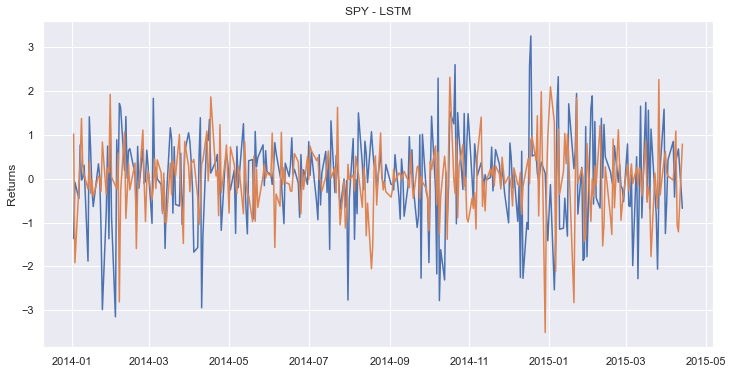

{'MAE': 0.007074659250101499, 'RMSE': 0.009212230959986844, 'MAPE': 409.3226456134479, 'Theil-U': 0.7092936314743177}
==========DIA==========
epoch:   0 train_loss: 0.0569777787 val_loss: 0.0102491295 
epoch:   2 train_loss: 0.0566596985 val_loss: 0.0103033697 
epoch:   4 train_loss: 0.0562159494 val_loss: 0.0103615588 
epoch:   6 train_loss: 0.0556875393 val_loss: 0.0104073947 
epoch:   8 train_loss: 0.0553507805 val_loss: 0.0103458073 
epoch:  10 train_loss: 0.0533326194 val_loss: 0.0106222983 
epoch:  12 train_loss: 0.2104825079 val_loss: 0.0327256098 
epoch:  14 train_loss: 0.0542053767 val_loss: 0.0106086163 
epoch:  16 train_loss: 0.0530172661 val_loss: 0.0106489705 
epoch:  18 train_loss: 0.0518852919 val_loss: 0.0111231608 
epoch:  20 train_loss: 0.0509151407 val_loss: 0.0109997718 
epoch:  22 train_loss: 0.0493239947 val_loss: 0.0112704802 
epoch:  24 train_loss: 0.0541072302 val_loss: 0.0119137429 
epoch:  26 train_loss: 0.0553232618 val_loss: 0.0141068567 
epoch:  28 train_l

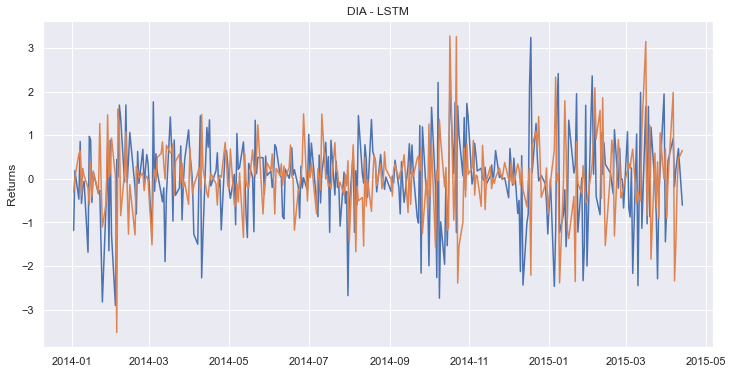

{'MAE': 0.00709941795954816, 'RMSE': 0.009576241029879806, 'MAPE': 939580854.4573913, 'Theil-U': 0.7262220466696097}
==========QQQ==========
epoch:   0 train_loss: 0.0792412534 val_loss: 0.0148829669 
epoch:   2 train_loss: 0.0783666298 val_loss: 0.0148489326 
epoch:   4 train_loss: 0.0774679109 val_loss: 0.0148012219 
epoch:   6 train_loss: 0.0765268058 val_loss: 0.0148831522 
epoch:   8 train_loss: 0.0754592046 val_loss: 0.0149904499 
epoch:  10 train_loss: 0.0762654990 val_loss: 0.0157222506 
epoch:  12 train_loss: 0.0743065551 val_loss: 0.0158337709 
epoch:  14 train_loss: 0.0733817518 val_loss: 0.0156263299 
epoch:  16 train_loss: 0.0743695796 val_loss: 0.0168413464 
epoch:  18 train_loss: 0.0740344375 val_loss: 0.0170196928 
epoch:  20 train_loss: 0.0744874254 val_loss: 0.0176172014 
epoch:  22 train_loss: 0.0742424950 val_loss: 0.0180580206 
epoch:  24 train_loss: 0.0712694973 val_loss: 0.0184394456 
epoch:  26 train_loss: 0.0723115355 val_loss: 0.0179707482 
epoch:  28 train_lo

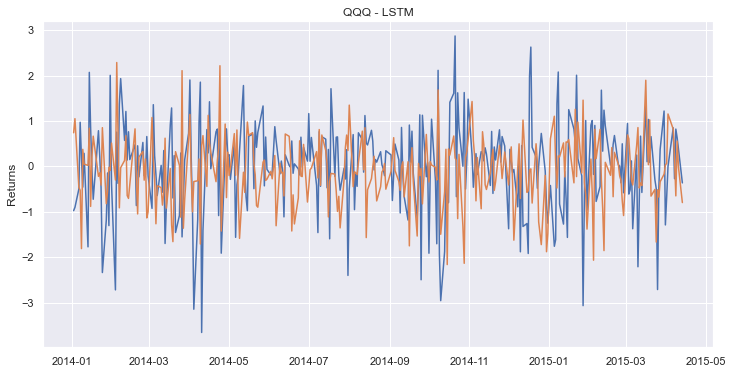

{'MAE': 0.008412401562700266, 'RMSE': 0.010929659859811898, 'MAPE': 54601181.09612309, 'Theil-U': 0.7137225806549493}


In [6]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4_baseline = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
modelPredictions_baseline = {}

for ETF in ETF_params:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    
    modelPredictions_baseline[ETF] = predicted
    
    Table4_baseline[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
    print(results)

In [7]:
Table4_baseline

,Statistic,SPY,DIA,QQQ
0,MAE,0.007075,7.099418e-03,8.412402e-03
1,MAPE,409.322646,9.395809e+08,5.460118e+07
2,RMSE,0.009212,9.576241e-03,1.092966e-02
3,THEIL-U,0.709294,7.262220e-01,7.137226e-01


### SAME TEST WITH DROPOUT AND L2 REGULARIZATION




==========SPY==========
epoch:   0 train_loss: 0.0689528137 val_loss: 0.0122093838 
epoch:   2 train_loss: 0.0688006580 val_loss: 0.0121540707 
epoch:   4 train_loss: 0.0682763532 val_loss: 0.0121842539 
epoch:   6 train_loss: 0.0675062388 val_loss: 0.0123761473 
epoch:   8 train_loss: 0.0667327791 val_loss: 0.0124559216 
epoch:  10 train_loss: 0.0682075843 val_loss: 0.0122937774 
epoch:  12 train_loss: 0.0714222938 val_loss: 0.0144621637 
epoch:  14 train_loss: 0.0700306743 val_loss: 0.0125760483 
epoch:  16 train_loss: 0.0760103837 val_loss: 0.0136739444 
epoch:  18 train_loss: 0.0668108836 val_loss: 0.0134979086 
epoch:  20 train_loss: 0.0638122633 val_loss: 0.0130493175 
epoch:  22 train_loss: 0.0667891055 val_loss: 0.0126584917 
epoch:  24 train_loss: 0.0611339286 val_loss: 0.0122420816 
epoch:  26 train_loss: 0.0664563328 val_loss: 0.0131065045 
epoch:  28 train_loss: 0.0614304058 val_loss: 0.0134847891 
epoch:  30 train_loss: 0.0591334105 val_loss: 0.0129017802 
epoch:  32 train

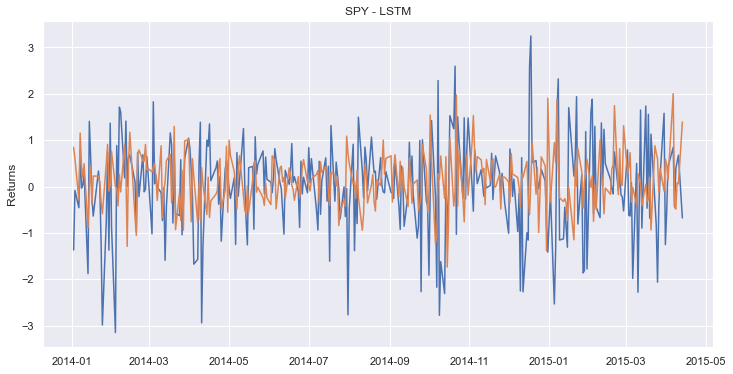

{'MAE': 0.006401720526265985, 'RMSE': 0.00835369756156516, 'MAPE': 379.4298227372749, 'Theil-U': 0.7049021868807662}
==========DIA==========
epoch:   0 train_loss: 0.0570349172 val_loss: 0.0102253044 
epoch:   2 train_loss: 0.0566811636 val_loss: 0.0102861486 
epoch:   4 train_loss: 0.0562441945 val_loss: 0.0103437779 
epoch:   6 train_loss: 0.0557717048 val_loss: 0.0103910696 
epoch:   8 train_loss: 0.0553506203 val_loss: 0.0103895171 
epoch:  10 train_loss: 0.1444208920 val_loss: 0.0104398141 
epoch:  12 train_loss: 0.0534509979 val_loss: 0.0105367685 
epoch:  14 train_loss: 0.0576605909 val_loss: 0.0105527388 
epoch:  16 train_loss: 0.0516646169 val_loss: 0.0105826221 
epoch:  18 train_loss: 0.0525162183 val_loss: 0.0111942161 
epoch:  20 train_loss: 0.0518101603 val_loss: 0.0107603334 
epoch:  22 train_loss: 0.0603144579 val_loss: 0.0116998395 
epoch:  24 train_loss: 0.0522794165 val_loss: 0.0119853579 
epoch:  26 train_loss: 0.0589031875 val_loss: 0.0143928882 
epoch:  28 train_lo

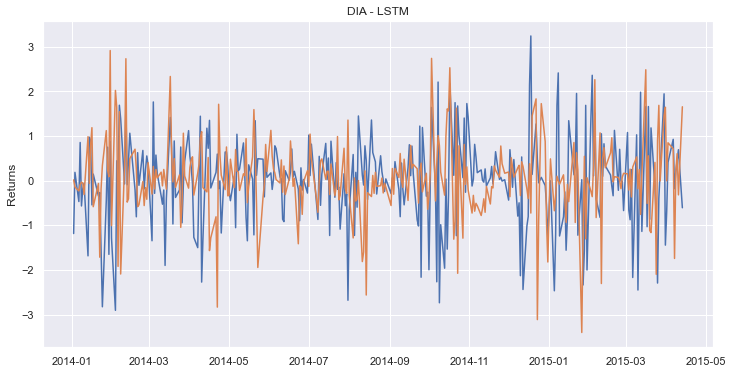

{'MAE': 0.007026055129461325, 'RMSE': 0.0095313076688122, 'MAPE': 544222092.0283884, 'Theil-U': 0.6984126845566861}
==========QQQ==========
epoch:   0 train_loss: 0.0793311521 val_loss: 0.0149011677 
epoch:   2 train_loss: 0.0785041749 val_loss: 0.0148543790 
epoch:   4 train_loss: 0.0776153058 val_loss: 0.0147719234 
epoch:   6 train_loss: 0.0764568970 val_loss: 0.0148653565 
epoch:   8 train_loss: 0.0752350613 val_loss: 0.0148171410 
epoch:  10 train_loss: 0.0741438046 val_loss: 0.0150556406 
epoch:  12 train_loss: 0.0734472573 val_loss: 0.0152691538 
epoch:  14 train_loss: 0.0726158991 val_loss: 0.0158558674 
epoch:  16 train_loss: 0.0739287511 val_loss: 0.0168788359 
epoch:  18 train_loss: 0.0696352869 val_loss: 0.0172292050 
epoch:  20 train_loss: 0.0765256360 val_loss: 0.0186715759 
epoch:  22 train_loss: 0.0864218920 val_loss: 0.0199025162 
epoch:  24 train_loss: 0.0733242631 val_loss: 0.0190752950 
epoch:  26 train_loss: 0.0744017363 val_loss: 0.0188632812 
epoch:  28 train_los

In [ ]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4 = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
modelPredictions = {}

for ETF in ETF_params:
    
    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    
    modelPredictions[ETF] = predicted
    Table4[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
    print(results)


In [ ]:
Table4

# Plot

In [ ]:
sns.set()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,6))

ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

for ETF in ["SPY", "DIA", "QQQ"]:
#     Totaldf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Total.pkl")
    # date column already as index
    Traindf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Train.pkl")
    Validdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Valid.pkl")
    Testdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Test.pkl") # out of sample
    
    # set frequency
    Traindf = Traindf.asfreq('d')
    Validdf = Validdf.asfreq('d')
    Testdf = Testdf.asfreq('d')
    
    # define targets
    trainTarget = Traindf['Return'].copy()
    validTarget = Validdf['Return'].copy()
    testTarget = Testdf['Return'].copy()
    
    # fit the model
    if ETF == "SPY":
        ARIMA_order = (8,0,8)
        AX = ax1 # for the plot
    elif ETF == "DIA":
        ARIMA_order = (10,0,10)
        AX = ax2 # for the plot
    else:
        ARIMA_order = (7,0,7)
        AX = ax3 # for the plot
    
    model = ARIMA(testTarget, order=ARIMA_order, missing='drop') # fit on the out of sample dataset => testTarget
    model_fit = model.fit(disp=0)
    
    fittedDf = pd.DataFrame({"Predictions":model_fit.predict()})
    
    # saving prediction
    os.makedirs(os.path.join("models_norm", ETF, "ARMA"), exist_ok=True)
    utils.save_file(fittedDf, os.path.join("models_norm", ETF, "ARMA", "Predictions.pkl"))
    
    # plot actual vs fitted
#     fittedDf = pd.DataFrame({"Predictions":model_fit.predict()})

#     fig, ax = plt.subplots(figsize = (12,6))
#     fig = sns.lineplot(x=Testdf.index, y='Return', data=Testdf, label="Targets")
#     sns.lineplot(x=fittedDf.index, y='Predictions', data=fittedDf, label="Predictions")
#     ax.set_ylabel('Returns')
#     ax.set_title(ETF + " - ARMA")
#     plt.show() 

    sns.lineplot(x=Testdf.index, y='Return', data=Testdf, label="Targets", ax=AX)
    sns.lineplot(x=fittedDf.index, y='Predictions', data=fittedDf, label="Predictions", ax=AX)
    AX.set_ylabel('Returns')
    AX.set_title(ETF + " - LSTM")
    AX.legend(loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig('table/LSTMplot.png', bbox_inches='tight')

# To Work

==========SPY==========
epoch:   0 train_loss: 0.0689009577 val_loss: 0.0122042242 
epoch:   2 train_loss: 0.0681518391 val_loss: 0.0121849868 
epoch:   4 train_loss: 0.0674570203 val_loss: 0.0123699438 
epoch:   6 train_loss: 0.0671955645 val_loss: 0.0123899681 
epoch:   8 train_loss: 0.0726767555 val_loss: 0.0130656138 
MAE : 0.0057 |  MAPE  : 146.8761 |  RMSE : 0.00749 | Theil-U 0.8203


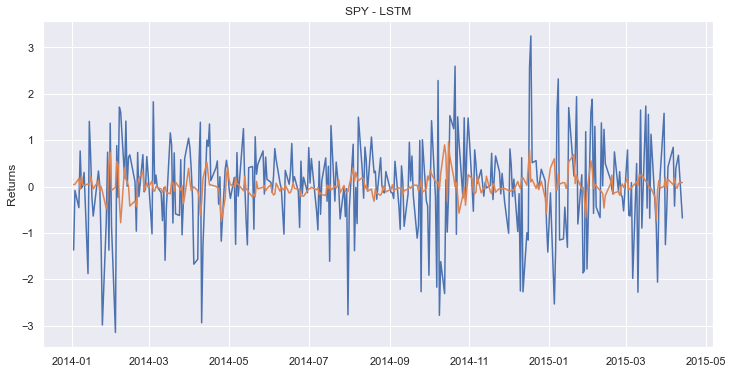

{'MAE': 0.0056523113944650025, 'RMSE': 0.007492577420864739, 'MAPE': 146.87614888357737, 'Theil-U': 0.8202901523401036}


In [138]:
ETF_params = {
              "SPY": {"epochs": 10, "lr":0.001},
              "DIA": {"epochs": 10, "lr":0.001},
              "QQQ": {"epochs": 10, "lr":0.001},
             }

Table4 = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

ETF = "SPY"

print("="*10 + ETF +"="*10)
train_data, valid_data, test_data =  get_etf_data(ETF)
model = LSTM()
train_model(model, train_data, valid_data, ETF_params[ETF])
results = evaluate_model(model, test_data)
predicted = predict(model, test_data)

Table4[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
print(results)